In [5]:
import pandas as pd
import numpy as np
import random
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import BatchNormalization
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

# Load the training data
train_data = pd.read_excel('E:\ML\JL\TrainingData.xlsx')
print(train_data.head(495))

# Preprocess the data
def preprocess_data(data):
    # Normalize the capacity values
    scaler = MinMaxScaler()
    data['Capacity'] = scaler.fit_transform(data[['Capacity']])

    # Assign numeric IDs to Battery_ID
    data['Battery_ID'] = data.groupby('Battery_ID').ngroup()

    # Sort the data by Battery_ID and Cycle
    data = data.sort_values(['Battery_ID', 'Cycle'])

    return data

train_data = preprocess_data(train_data)

# Define the maximum sequence length
max_length = 495

# Reshape the data into sequences
def reshape_data(data, max_length):
    grouped = data.groupby('Battery_ID')
    sequences = [group[['Capacity']].values for _, group in grouped]
    return pad_sequences(sequences, maxlen=max_length, dtype='float32', padding='post', truncating='post')

X_train = reshape_data(train_data, max_length)

print(train_data.head(495))

from tensorflow.keras.layers import GRU, Dropout, RepeatVector, TimeDistributed, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Build the GRU autoencoder model with regularization
model = Sequential([
    GRU(128, activation='relu', return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]),
        kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.2),
    GRU(64, activation='relu', return_sequences=False,
        kernel_regularizer=regularizers.l2(0.01)),
    RepeatVector(X_train.shape[1]),
    GRU(64, activation='relu', return_sequences=True),
    Dropout(0.2),
    GRU(128, activation='relu', return_sequences=True),
    TimeDistributed(Dense(1))
])

model.compile(optimizer='adam', loss='mse')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
#model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_loss', mode='min')

history = model.fit(X_train, X_train, epochs=50, batch_size=32, validation_split=0.2,
                    callbacks=[early_stopping])


     Cycle Battery_ID  Capacity
0        1         B1  1.000425
1        2         B1  0.999683
2        3         B1  0.998722
3        4         B1  0.998003
4        5         B1  0.997993
..     ...        ...       ...
490    491         B1  0.873978
491    492         B1  0.874048
492    493         B1  0.873322
493    494         B1  0.873158
494    495         B1  0.875418

[495 rows x 3 columns]
     Cycle  Battery_ID  Capacity
0        1           0  0.972096
1        2           0  0.967233
2        3           0  0.960930
3        4           0  0.956210
4        5           0  0.956148
..     ...         ...       ...
490    491           0  0.142747
491    492           0  0.143210
492    493           0  0.138445
493    494           0  0.137371
494    495           0  0.152194

[495 rows x 3 columns]


C:\Users\User\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 49s 49s/step - loss: 1.9512 - val_loss: 1.9543
Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step - loss: 1.8976 - val_loss: 1.8984
Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.8437 - val_loss: 1.8395
Epoch 4/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.7869 - val_loss: 1.7772
Epoch 5/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.7272 - val_loss: 1.7116
Epoch 6/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.6646 - val_loss: 1.6422
Epoch 7/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.5998 - val_loss: 1.5693
Epoch 8/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.5297 - val_loss: 1.4937
Epoch 9/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.4589 - val_loss: 1.4177
Epoch 10/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.3929 - val_loss: 1.3468
Epoch 11/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.3282 - val_loss: 1.2924
Epoch 12/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - loss: 1.2844 - val_loss: 1.2716
Epoch 13/50
1/1 ━━━━━━━

In [6]:
#Reconstructions loss

# Evaluate the model
reconstruction_loss = model.predict(X_train)
train_loss = np.mean(np.abs(reconstruction_loss - X_train), axis=(1, 2))

# Determine the threshold
threshold =np.percentile(train_loss, 80)

print(f'Threshold for anomaly detection: {threshold}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
Threshold for anomaly detection: 0.21587426960468292


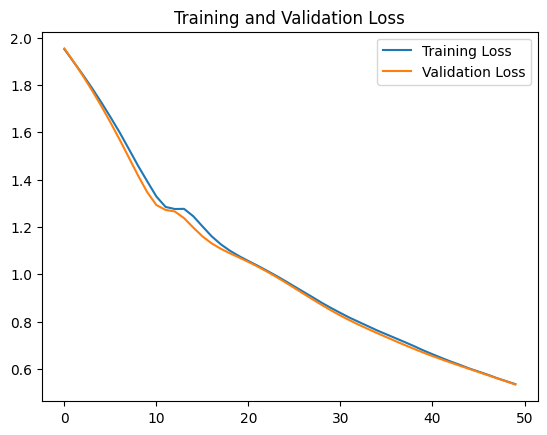

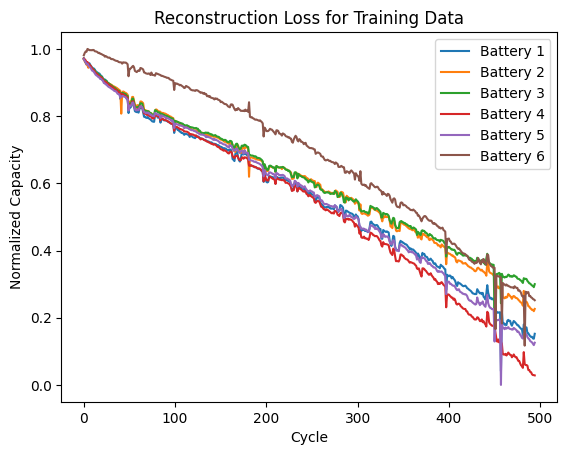

In [7]:
# Plot the training and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()
# Plot the reconstruction loss for all batteries in the training data
for i in range(X_train.shape[0]):
    plt.plot(X_train[i, :, 0], label=f'Battery {i+1}')
plt.title('Reconstruction Loss for Training Data')
plt.xlabel('Cycle')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.show()


In [8]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the testing data
test_data = pd.read_excel('E:\ML\JL\TestingData.xlsx')
print(test_data.head(499))

# Preprocess the data
def preprocess_data(data):
    # Normalize the capacity values
    scaler = MinMaxScaler()
    data['Capacity'] = scaler.fit_transform(data[['Capacity']])

    # Create a new column for the battery ID
    data['Battery_ID'] = data.groupby('Battery_ID').ngroup()

    # Sort the data by battery ID and cycle
    data = data.sort_values(['Battery_ID', 'Cycle'])

    return data

test_data = preprocess_data(test_data)

# Define the maximum sequence length
max_length = 495

# Reshape the data into sequences
def reshape_data(data, max_length):
    grouped = data.groupby('Battery_ID')
    sequences = []

    for _, group in grouped:
        seq = group[['Capacity']].values
        sequences.append(seq)

    return pad_sequences(sequences, maxlen=max_length, dtype='float32', padding='post', truncating='post')

X_test = reshape_data(test_data, max_length)
print(test_data.head(495))

     Cycle Battery_ID  Capacity
0        1         B1  0.999216
1        2         B1  0.998092
2        3         B1  0.997206
3        4         B1  0.996253
4        5         B1  0.995537
..     ...        ...       ...
494    495         B1  0.640988
495    496         B1  0.639150
496    497         B1  0.627647
497    498         B1  0.623800
498    499         B1  0.620841

[499 rows x 3 columns]
     Cycle  Battery_ID  Capacity
0        1           0  0.998838
1        2           0  0.995870
2        3           0  0.993532
3        4           0  0.991014
4        5           0  0.989125
..     ...         ...       ...
490    491           0  0.043177
491    492           0  0.025417
492    493           0  0.020569
493    494           0  0.057111
494    495           0  0.053183

[495 rows x 3 columns]


In [9]:
 # Evaluate the model
reconstructions_test = model.predict(X_test)
test_loss = np.mean(np.abs(reconstructions_test - X_test), axis=(1, 2))

# Detect anomalies in the testing data
anomalies_test = (test_loss > threshold).astype(int)

# Calculate the number of anomalies in the testing data
num_anomalies_test = np.sum(anomalies_test)

print(test_loss)
print(f'Number of Anomalies in Testing Data: {num_anomalies_test}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
[0.28391126 0.26204416 0.22620997 0.21625164 0.21188755 0.20145589]
Number of Anomalies in Testing Data: 4


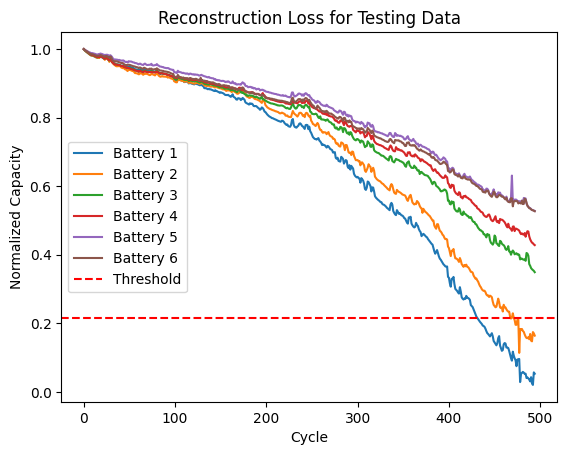

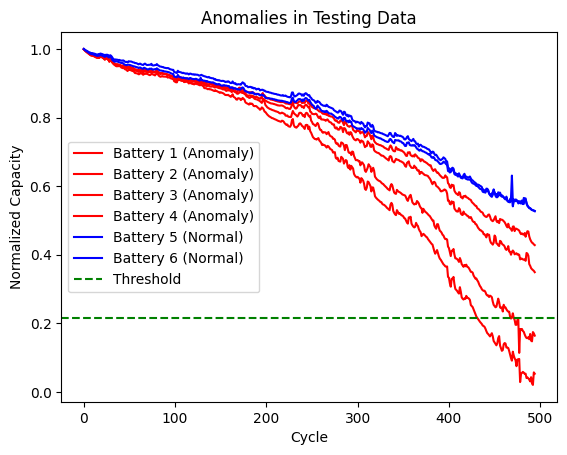

Cycles to Anomaly: [309, 332, 388, 402, -1, -1]
Threshold: 0.21587426960468292


In [14]:
# Plot the reconstruction loss for all batteries in the testing data
for i in range(X_test.shape[0]):
    plt.plot(X_test[i, :, 0], label=f'Battery {i+1}')
plt.axhline(y=threshold, color='red', linestyle='--', label='Threshold')
plt.title('Reconstruction Loss for Testing Data')
plt.xlabel('Cycle')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.show()

# Plot the anomalies in the testing data
for i in range(X_test.shape[0]):
    if anomalies_test[i] == 1:
        plt.plot(X_test[i, :, 0], color='red', label=f'Battery {i+1} (Anomaly)')
    else:
        plt.plot(X_test[i, :, 0], color='blue', label=f'Battery {i+1} (Normal)')
plt.axhline(y=threshold, color='green', linestyle='--', label='Threshold')
plt.title('Anomalies in Testing Data')
plt.xlabel('Cycle')
plt.ylabel('Normalized Capacity')
plt.legend()
plt.show()

# Calculate the number of cycles after which anomaly shows
cycles_to_anomaly = []
for i in range(X_test.shape[0]):
    if anomalies_test[i] == 1:
        anomaly_cycle = np.argmax(X_test[i, :, 0] < 0.6) + 1
        cycles_to_anomaly.append(anomaly_cycle)
    else:
        cycles_to_anomaly.append(-1)

print(f'Cycles to Anomaly: {cycles_to_anomaly}')

print(f'Threshold: { threshold}')




In [15]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

anomalies_array = np.array(anomalies_test)

# Print the first few elements of the anomalies array
print("Test anomalies:",anomalies_array)

# Actual anomalies
actual_anomalies = [1, 1, 1, 1, 0, 0]

# Convert actual_anomalies to a numpy array
actual_anomalies_array = np.array(actual_anomalies)

# Ensure both arrays contain only binary values
assert set(anomalies_array).issubset({0, 1}), "anomalies_test contains non-binary values"
assert set(actual_anomalies_array).issubset({0, 1}), "actual_anomalies contains non-binary values"

# Calculate accuracy, precision, recall, and F1 score
accuracy = accuracy_score(actual_anomalies_array, anomalies_array)
precision = precision_score(actual_anomalies_array, anomalies_array)
recall = recall_score(actual_anomalies_array, anomalies_array)
f1 = f1_score(actual_anomalies_array, anomalies_array)

# Print the scores
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Test anomalies: [1 1 1 1 0 0]
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0
